In [1]:
"""
Plot vertical profiles of  qg (specific graupel content) and
number concentrations for each cloud class.

Available number concentrations for 2-moment microphysics:
- qnc  number concentration cloud droplets [kg-1]
- qni  number concentration cloud ice [kg-1]
- qns  number concentration snow [kg-1]
- qnr  number concentration rain droplet [kg-1]
- qng  number concentration graupel [kg-1]
- qh   specific hail content [kg kg-1]
- qnh  number concentration hail [kg-1]
"""

import matplotlib.pyplot as plt
#import matplotlib as mpl
import numpy as np
import xarray as xr

import sys
sys.path.append('/pf/b/b380490/jupyter_notebooks/nawdex_hackathon')
import dict_nawdexsims

simdict = dict_nawdexsims.simdictionary()
colordict = dict_nawdexsims.colordictionary()

#import dask
#from dask.distributed import Client
#client = Client()
#client

In [2]:
# get height at full levels
def get_fulllevel_height():
    # define simulation
    resolution = '80km'
    sim = '0001'
    expid = 'nawdexnwp-' + resolution + '-mis-' + sim

    # read ocean mask
    ipath_oceanmask = '/work/bb1018/nawdex-hackathon_pp/'
    da_ocean = xr.open_dataset(ipath_oceanmask + '/openoceanmask/' + expid + \
                               '_openoceanmask.nc')['mask_openocean']
    index = np.where(da_ocean == 1)[0]
    del da_ocean, ipath_oceanmask

    # read z_ifc data
    ipath = '/work/bb1018/b380459/NAWDEX/ICON_OUTPUT_NWP/' + \
            'nawdexnwp-' + resolution + '-mis-' + sim + '/'
    ds = xr.open_dataset(ipath + 'nawdexnwp-' + resolution + '-mis-' + \
                         sim + '_2016092200_fg_DOM01_ML_0036.nc')
    del ipath

    # apply ocean mask on z_ifc to make sure to look at ocean grid point
    ds = ds.isel(ncells=index)

    # calculate full levels based on z_ifc
    z_full = (ds.z_ifc[:,0] - (ds.z_ifc[:,0].diff('height_3')/2)).values

    #print(z_full)

    del resolution, sim, expid, index, ds
    
    return z_full

zfull = get_fulllevel_height()

#print(zfull)

In [3]:
# thresholds for cloud classes
# 'hq62_mq67_lq30', 'hq60_mq60_lq25', 'hq65_mq70_lq35'
threshold = 'hq62_mq67_lq30'

ipath = '/work/bb1018/nawdex-hackathon_pp/cloudclasses/' + \
        'qg_qnx_for_cloudclass/'
opath = '/pf/b/b380490/jupyter_notebook_output/nawdex_hackathon/'

# simulation setups
resolutions = ['80km', '40km', '20km', '10km', '5km', '2km', '2km-shcon']
mphysics = [1, 2]
#conv = 1

# cloud classes
ncclass = 8 # number of cloud classes
cclasses = ['High (H)', 'Middle (M)', 'Low (L)',
            'H-M', 'M-L', 'H-L', 'H-M-L', 'clear sky']
cclass_save = ['H', 'M', 'L', 'H-M', 'M-L', 'H-L', 'H-M-L', 'clearsky']

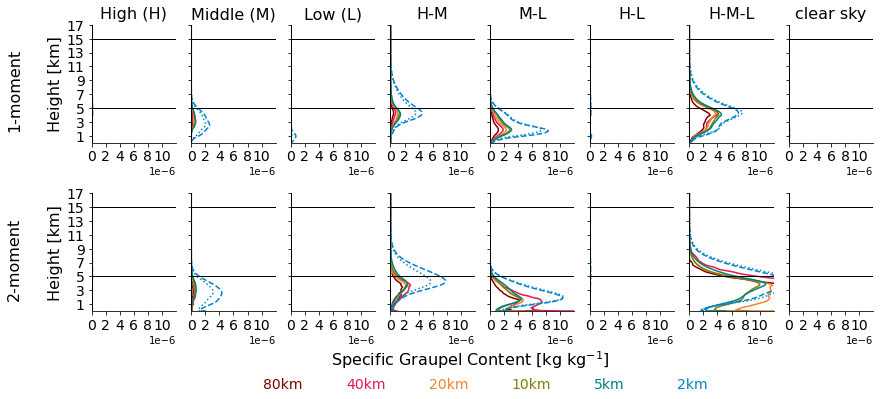

In [19]:
# Overview plots - specific graupel content (qg)
# all classes, all heights, both microphysics schemes in one figure

var = 'qg'

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(2, 8, figsize=(11.5, 5), sharey=True)
for mphys in mphysics:
    for res in resolutions:
        if res in ['80km', '40km', '20km', '10km', '5km']:
            conv = 1
            lstyle='-'
        elif res == '2km':
            conv = 0
            lstyle = '--'
        elif res == '2km-shcon':
            conv = 2
            lstyle = ':'
            res = '2km'

        # get all expids for simulations with same configuration
        expids = [key for key in simdict if simdict[key]['res'] == res and \
                                            simdict[key]['conv'] == conv and \
                                            simdict[key]['mphys'] == mphys]
        #print(expids)

        # read variable from all simulations that have the same
        # configuration
        data = []
        for expid in expids:
            ds = xr.open_dataset(ipath + expid + \
                                 '_qg_qnx_cloudclasses_' + \
                                 'areamean_timemean_oceanmask_applied_' + \
                                 threshold + '.nc')
            data.append(ds)
            del ds
        
        # merge data with same configuration and get mean over simulations
        ds = xr.concat([x for x in data], 'nsim')
        ds = ds.mean('nsim')

        #print(ds)

        del data, expid

        # plot cloud cover for different cloud classes
        for c in range(ncclass):#-1):
            ax[mphys-1, c].plot(ds[var + '_cclass' + str(c+1)], zfull/1000,
                                color=colordict[res], linestyle=lstyle, label=res)
            ax[mphys-1, c].tick_params(labelsize=14)
            ax[mphys-1, c].spines['right'].set_color('none')
            ax[mphys-1, c].spines['top'].set_color('none')
            ax[mphys-1, c].spines['left'].set_color('none')
            #ax[mphys-1, c].spines['left'].set_position('zero')
            ax[mphys-1, c].axvline(0, linewidth=1, color='k')
            ax[mphys-1, c].set_yticks(np.arange(1, 31, 2))
            ax[mphys-1, c].set_ylim(0, 17)# (5, 15)#(0, 17)
            if ax[mphys-1, c].get_ylim() == (0.0, 17.0):
                ax[mphys-1, c].axhline(5, linewidth=1, color='k')
                ax[mphys-1, c].axhline(15, linewidth=1, color='k')
            ax[mphys-1, c].ticklabel_format(axis='x', scilimits=(-6,-6))
            ax[mphys-1, c].set_xticks(np.arange(0, 10e-6, 2e-6))
            ax[mphys-1, c].set_xlim(0, 12e-6)
            # for 5-15 km:
            #if ax[mphys-1, c].get_ylim() == (5.0, 15.0):
            #    ax[mphys-1, c].set_xlim(-0.2, 0.55)
            ## for 0-17 km:
            #elif ax[mphys-1, c].get_ylim() == (0.0, 17.0):
            #    ax[mphys-1, c].set_xlim(-0.4, 0.55)
            ax[0, c].set_title(cclasses[c], fontsize=16)
        del c
        del ds
    del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.08, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

ax[0, 0].set_ylabel('Height [km]', fontsize=16)
ax[1, 0].set_ylabel('Height [km]', fontsize=16)
fig.text(0.5, -0.01, 'Specific Graupel Content [kg kg$^{-1}$]',
         rotation='horizontal', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.74, '1-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)
fig.text(-0.05, 0.27, '2-moment',
         rotation='vertical', ha='center', va='center', fontsize=16)


#fig.savefig(opath + var + '_profile_cloudclasses_overview_' + \
#            threshold + '_0-17km.png', dpi=400, #pdf',
#            bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax

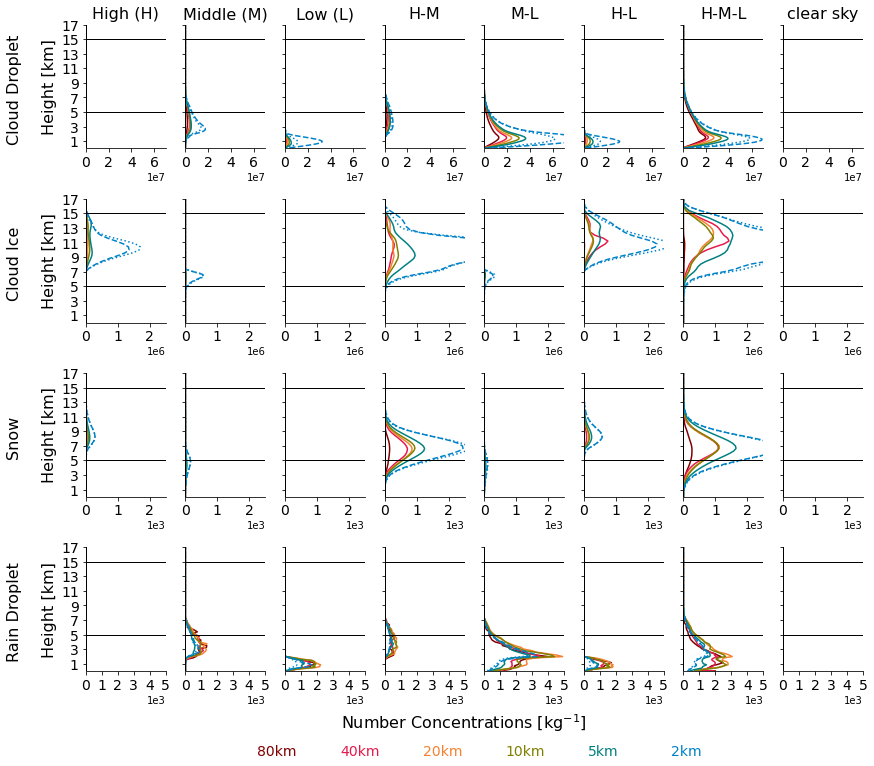

In [37]:
# Overview plots - number concentration cloud droplets (qnc)
# all classes, all heights, 2-moment microphysics scheme in one figure

#- qnc  number concentration cloud droplets [kg-1]
#- qni  number concentration cloud ice [kg-1]
#- qns  number concentration snow [kg-1]
#- qnr  number concentration rain droplet [kg-1]
qnx_plot = ['qnc', 'qni', 'qns', 'qnr']

mphys = 2

# open figure, add lines with each iteration over the resolutions
# and cloud classes
fig, ax = plt.subplots(4, 8, figsize=(11.5, 10), sharey=True)
for res in resolutions:
    if res in ['80km', '40km', '20km', '10km', '5km']:
        conv = 1
        lstyle='-'
    elif res == '2km':
        conv = 0
        lstyle = '--'
    elif res == '2km-shcon':
        conv = 2
        lstyle = ':'
        res = '2km'

    # get all expids for simulations with same configuration
    expids = [key for key in simdict if simdict[key]['res'] == res and \
                                        simdict[key]['conv'] == conv and \
                                        simdict[key]['mphys'] == mphys]
    #print(expids)

    # read variable from all simulations that have the same
    # configuration
    data = []
    for expid in expids:
        ds = xr.open_dataset(ipath + expid + \
                             '_qg_qnx_cloudclasses_' + \
                             'areamean_timemean_oceanmask_applied_' + \
                             threshold + '.nc')
        data.append(ds)
        del ds

    # merge data with same configuration and get mean over simulations
    ds = xr.concat([x for x in data], 'nsim')
    ds = ds.mean('nsim')

    #print(ds)

    del data, expid

    # plot cloud cover for different cloud classes
    for c in range(ncclass):#-1):
        for i, qnx in enumerate(qnx_plot):
            ax[i, c].plot(ds[qnx + '_cclass' + str(c+1)], zfull/1000,
                                color=colordict[res], linestyle=lstyle, label=res)
            ax[i, c].tick_params(labelsize=14)
            ax[i, c].spines['right'].set_color('none')
            ax[i, c].spines['top'].set_color('none')
            ax[i, c].spines['left'].set_color('none')
            ax[i, c].axvline(0, linewidth=1, color='k')
            ax[i, c].set_yticks(np.arange(1, 31, 2))
            ax[i, c].set_ylim(0, 17)# (5, 15)#(0, 17)
            if ax[i, c].get_ylim() == (0.0, 17.0):
                ax[i, c].axhline(5, linewidth=1, color='k')
                ax[i, c].axhline(15, linewidth=1, color='k')

            ax[0, c].set_title(cclasses[c], fontsize=16)
        del i, qnx
        # qnc
        ax[0, c].ticklabel_format(axis='x', scilimits=(7,7))
        ax[0, c].set_xticks(np.arange(0, 10e7, 2e7))
        ax[0, c].set_xlim(0, 7e7)
        # qni
        ax[1, c].ticklabel_format(axis='x', scilimits=(6,6))
        ax[1, c].set_xticks(np.arange(0, 3e6, 1e6))
        ax[1, c].set_xlim(0, 2.5e6)
        # qns
        ax[2, c].ticklabel_format(axis='x', scilimits=(3,3))
        ax[2, c].set_xticks(np.arange(0, 10e3, 1e3))
        ax[2, c].set_xlim(0, 2.5e3)
        # qnr
        ax[3, c].ticklabel_format(axis='x', scilimits=(3,3))
        ax[3, c].set_xticks(np.arange(0, 10e3, 1e3))
        ax[3, c].set_xlim(0, 5e3)
    del c
    del ds
del res

fig.tight_layout()

# legend: text for lines
#xloc = [0.18, 0.41, 0.55, 0.18, 0.41, 0.55, 0.7]
xloc = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for r, res in enumerate(resolutions[:-1]):
    fig.text(xloc[r], -0.05, resolutions[r], color=colordict[res],
             ha='left', va='center', rotation='horizontal', fontsize=14,
             backgroundcolor='white')
del r, res, xloc

ax[0, 0].set_ylabel('Cloud Droplet \n\nHeight [km]', fontsize=16)
ax[1, 0].set_ylabel('Cloud Ice \n\nHeight [km]', fontsize=16)
ax[2, 0].set_ylabel('Snow \n\nHeight [km]', fontsize=16)
ax[3, 0].set_ylabel('Rain Droplet \n\nHeight [km]', fontsize=16)
fig.text(0.5, -0.01, 'Number Concentrations [kg$^{-1}$]',
         rotation='horizontal', ha='center', va='center', fontsize=16)

#fig.savefig(opath + 'qnx_profile_cloudclasses_overview_' + \
#            threshold + '_0-17km.png', dpi=400, #pdf',
#            bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del mphys
del fig, ax